In [1]:
import time, os
from pathlib import Path

import torch
torch.manual_seed(123456789)
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.models as models
from datetime import date, datetime

import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
from scipy.stats import norm

In [2]:
try:
    from glasses.models import AutoModel, AutoTransform
except ImportError:
    print("To use RegNet, please install glasses module at https://github.com/FrancescoSaverioZuppichini/glasses \n Feel free to use other training methods.")

In [3]:
# Make your choice here, note index starts at 0
#           0                      1           2            3                   4
choices = ["Tang et al.'s model", "ResNet34", "RegNet02x", "10_percent_data", "Transfer_learning"]
choice = choices[2]

In [4]:
path_data = str(Path("data/tiles").resolve())
csv_data = str(Path("data/tiles/CSV").resolve())

if choice in ["Tang et al.'s model", "ResNet34", "RegNet02x"]:
        csv_path = {
                'train': os.path.join(csv_data, "upsampled_train.csv"),
                'dev': os.path.join(csv_data, "rebalanced_validation.csv"),
        }

if choice in ["10_percent_data", "Transfer_learning"]:
        csv_path = {
                "train": os.path.join(csv_data, "train_10pct.csv"),
                "dev": os.path.join(csv_data, "rebalanced_validation.csv") 
        }

path_train = os.path.join(path_data, "all_data")
path_validation = os.path.join(path_data, "all_data")

DATA_DIR = path_train
SAVE_DIR = 'models/'

train_losses = []
dev_losses = []

image_classes = ['cored','diffuse','CAA']

if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)
        
csv_path

{'train': '/workspace/data/tiles/CSV/upsampled_train.csv',
 'dev': '/workspace/data/tiles/CSV/rebalanced_validation.csv'}

In [5]:
'''
Tang et al.'s model
'''
class Net(nn.Module):

    def __init__(self, fc_nodes=512, num_classes=3, dropout=0.5):
        super(Net, self).__init__()
        
        self.drop = 0.2
     
        self.features = nn.Sequential(nn.Conv2d(3, 64, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(64, 64, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(64, 128, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(128, 256, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(256, 256, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),
                                      
                                      nn.Conv2d(256, 512, 3, padding=1),
                                      nn.Dropout2d(self.drop),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=2, stride=2),)
        
        self.classifier = nn.Sequential(nn.Linear(512 * 4 * 4, fc_nodes),
                                        nn.ReLU(True),
                                        nn.Dropout(p=dropout),
                                        nn.Linear(fc_nodes, 100),
                                        nn.ReLU(True),
                                        nn.Dropout(p=dropout),
                                        nn.Linear(100, num_classes))
        
        self.train_loss_curve = []
        self.dev_loss_curve = []

    def forward(self, x):
 
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x

In [6]:
batch_size = 32
num_workers = 20
num_classes = 3
norm = np.load('utils/normalization.npy', allow_pickle=True).item()

if choice in ["ResNet34", "Transfer_learning"]:
    model = models.resnet34()

    if choice == "Transfer_learning" : # Freeze Layers
        for param in model.parameters():
            param.requires_grad = False
    
    # Modify final layer
    model.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)

elif choice == "Tang et al.'s model":
    model = Net()
    
elif choice in ["RegNet02x", "10_percent_data"]:
    model = AutoModel.from_pretrained('regnetx_002', n_classes=3).eval()

    # if choice == "Transfer_learning":
    #     model.freeze(who=model.encoder)

# Load onto GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# View Model to validate
print(model)


[05/10/22 08:21:10] WARNING  Error(s) in loading state_dict for RegNet:      ]8;id=318763;file:///miniconda3/lib/python3.8/site-packages/glasses/models/AutoModel.py\AutoModel.py]8;;\:]8;id=877677;file:///miniconda3/lib/python3.8/site-packages/glasses/models/AutoModel.py#234\234]8;;\
                                     size mismatch for head.fc.weight:                       
                             copying a param with shape torch.Size([1000,                    
                             368]) from checkpoint, the shape in current                     
                             model is torch.Size([3, 368]).                                  
                                     size mismatch for head.fc.bias: copying                 
                             a param with shape torch.Size([1000]) from                      
                             checkpoint, the shape in current model is                       
                             torch.Size([3]).                                                

                    INFO     Loaded pretrained weights for regnetx_002       ]8;id=790870;file:///miniconda3/lib/python3.8/site-packages/glasses/models/AutoModel.py\AutoModel.py]8;;\:]8;id=621734;file:///miniconda3/lib/python3.8/site-packages/glasses/models/AutoModel.py#235\235]8;;\

RegNet(
  (encoder): ResNetEncoder(
    (stem): ConvNormAct(
      (conv): Conv2dPad(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
    )
    (layers): ModuleList(
      (0): ResNetLayer(
        (0): RegNetXBotteneckBlock(
          (block): Sequential(
            (0): ConvNormAct(
              (conv): Conv2dPad(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (norm): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (act): ReLU(inplace=True)
            )
            (1): ConvNormAct(
              (conv): Conv2dPad(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
              (norm): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (act): ReLU(inplace=True)
            )
            (2): ConvNor

In [7]:
from torch.utils.data import Dataset
from PIL import Image

class MultilabelDataset(Dataset):
    def __init__(self, csv_path, img_path, transform=None):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.data_info = pd.read_csv(csv_path)
        self.img_path = img_path
        self.transform = transform
        c=torch.Tensor(self.data_info.loc[:,'cored'])
        d=torch.Tensor(self.data_info.loc[:,'diffuse'])
        a=torch.Tensor(self.data_info.loc[:,'CAA'])
        c=c.view(c.shape[0],1)
        d=d.view(d.shape[0],1)
        a=a.view(a.shape[0],1)
        self.raw_labels = torch.cat([c,d,a], dim=1)
        self.labels = (torch.cat([c,d,a], dim=1)>0.99).type(torch.FloatTensor)

    def __getitem__(self, index):
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.labels[index]
        raw_label = self.raw_labels[index]
        # Get image name from the pandas df
        single_image_name = str(self.data_info.loc[index,'imagename'])
        # Open image
        try:
            img_as_img = Image.open(os.path.join(self.img_path, single_image_name))
        except:
            print("Loading image error. Please check image data folder.")
        # Transform image to tensor
        if self.transform is not None:
            img_as_img = self.transform(img_as_img)
        # Return image and the label
        return (img_as_img, single_image_label, raw_label, single_image_name)

    def __len__(self):
        return len(self.data_info.index)

In [8]:
def imshow(inp, norm, title=None):
    """Imshow for Tensor."""
    try:
        inp = inp.numpy().transpose((1, 2, 0))
    except:
        inp = inp.transpose((1, 2, 0))
    mean = norm['mean']
    std = norm['std']
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.subplots()
    ax.imshow(inp)
    
    if title is not None:
        ax.set_title(title)
    plt.pause(0.001)

In [9]:
def plot_loss(model):
    fig = plt.figure()
    fig.subplots_adjust(left=2, right = 3, wspace=0.3, bottom = 2, top = 3)
    ax = plt.axes()
    for i in range(len(train_losses)):
        train_losses[i] = float(train_losses[i])
        dev_losses[i] = float(dev_losses[i])
    ax.plot(train_losses, label='train')
    ax.plot(dev_losses, label='dev')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend()

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, gpu_id=None):
    since = time.time()

    best_loss = 10000.0
    best_model = copy.deepcopy(model)

    for epoch in range(num_epochs):
        epoch_time = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'dev']:
            if phase == 'train':
                
                model.train(True)  
            else:
                model.train(False)  

            running_loss = 0.0
            running_corrects = torch.zeros(len(image_classes))

            # Iterate over data.
            if phase == 'train':
                for data in dataloaders[phase]:
                    # get the inputs
                    inputs, labels, raw_labels, names = data
                    # wrap them in Variable
                    if use_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    else:
                        inputs = inputs
                        labels = labels

                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward
                    outputs = model(inputs)
                    if use_gpu:
                        predictions = (torch.sigmoid(outputs)>0.5).type(torch.cuda.FloatTensor)
                    else:
                        predictions = (torch.sigmoid(outputs)>0.5).type(torch.FloatTensor)

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    loss.backward()
                    optimizer.step()

                    # statistics
                    running_loss += loss.data
                    running_corrects += torch.sum(predictions==labels, 0).data.type(torch.FloatTensor)
            else:
                with torch.no_grad(): 
                    for data in dataloaders[phase]:
                        # get the inputs
                        inputs, labels, raw_labels, names = data
                        # wrap them in Variable
                        if use_gpu:
                            inputs = inputs.cuda()
                            labels = labels.cuda()
                        else:
                            inputs = inputs
                            labels = labels

                        # zero the parameter gradients
                        optimizer.zero_grad()
                        # forward
                        outputs = model(inputs)
                        if use_gpu:
                            predictions = (torch.sigmoid(outputs)>0.5).type(torch.cuda.FloatTensor)
                        else:
                            predictions = (torch.sigmoid(outputs)>0.5).type(torch.FloatTensor)

                        loss = criterion(outputs, labels)

                        # statistics
                        running_loss += loss.data
                        running_corrects += torch.sum(predictions==labels, 0).data.type(torch.FloatTensor)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                dev_losses.append(epoch_loss)

            if phase == 'dev' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model = copy.deepcopy(model)

            print('{} Loss: {:.4f}\n Cored: {:.4f} Diffuse: {:.4f} CAA: {:.4f}'.format(
                phase, epoch_loss, epoch_acc[0], epoch_acc[1], epoch_acc[2]))

        scheduler.step()
        epoch_end = time.time() - epoch_time
        print('train, Epoch time {:.0f}m {:.0f}s'.format(
                epoch_end // 60, epoch_end % 60))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return best_model

In [11]:
if choice in ["Tang et al.'s model", "ResNet34", "Transfer_learning"]:
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(180),
            transforms.ColorJitter(brightness=0.1, contrast=0.2,saturation=0.2, hue=0.02),
            transforms.RandomAffine(0, translate=(0.05,0.05), scale=(0.9,1.1), shear=10),
            transforms.ToTensor(),
            transforms.Normalize(norm['mean'], norm['std'])
        ]),
        'dev': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(norm['mean'], norm['std'])
        ]),
    }
elif choice in ["RegNet02x", "10_percent_data"]:
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(size=256, interpolation=transforms.InterpolationMode.BICUBIC, max_size=None, antialias=None),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(180),
            transforms.ColorJitter(brightness=0.1, contrast=0.2,saturation=0.2, hue=0.02),
            transforms.RandomAffine(0, translate=(0.05,0.05), scale=(0.9,1.1), shear=10),
            transforms.ToTensor(),
            transforms.Normalize(norm['mean'], norm['std'])
        ]),
        'dev': transforms.Compose([
            transforms.Resize(size=256, interpolation=transforms.InterpolationMode.BICUBIC, max_size=None, antialias=None),
            transforms.ToTensor(),
            transforms.Normalize(norm['mean'], norm['std'])
        ]),
    }

image_datasets_tarin = MultilabelDataset(csv_path['train'], path_train, data_transforms['train'])
image_datasets_dev = MultilabelDataset(csv_path['dev'], path_validation, data_transforms['dev'])
image_datasets = {'train': image_datasets_tarin, 'dev': image_datasets_dev}
        
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
                  for x in ['dev', 'train']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'dev']}

use_gpu = torch.cuda.is_available()

dataset_sizes

{'train': 157911, 'dev': 7106}

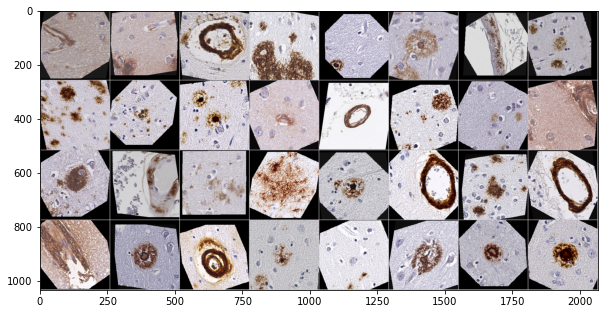

In [12]:
# Get a batch of training data
inputs, labels, raw_labels, names = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, norm)

In [13]:
weight = torch.FloatTensor([1,1,1])

if use_gpu:
    print('gpu')
    weight = weight.cuda()
    model = nn.DataParallel(model, device_ids=[0,1])
    model = model.cuda()
    
# criterion = nn.MultiLabelSoftMarginLoss(weight=weight, size_average=False)
criterion = nn.MultiLabelSoftMarginLoss(weight=weight, reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.02)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.4)

gpu


In [ ]:
best_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=30)

In [15]:

torch.save(model, SAVE_DIR+choice+ str(datetime.now()) + ".pkl")

In [ ]:
plot_loss(model.module)